# 02 – Admin Boundaries (Prelim)

**Goal**:
- Build a clean "base map" for the Sundarbans AOI (India + Bangladesh)
- Overlay the CEAM bbox
- This notebook intentionally starts with only local Natural Earth basemaps.


**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box


**Path and Bounding Box**

### CEAM AOI Bounding Box — Sundarbans Region

The bounding box used for all CEAM analyses is based on published geographic extents of the **Sundarbans mangrove delta**, which spans southern Bangladesh and eastern India.  
According to multiple sources — including the *Bangladesh Forest Department* and research summaries such as *Giri et al. (2015), Remote Sensing of Environment, 167, 201–214* — the Sundarbans extends approximately between **21°30′–22°40′ N** and **88°05′–89°55′ E**.

Adopting these limits, the CEAM bounding box is fixed as:

```python
bbox = {
    "lon_min": 88.08,
    "lat_min": 21.50,
    "lon_max": 89.92,
    "lat_max": 22.67,
}


In [2]:
# Adjust if your repo paths differ
NE_DIR = "../data/basemaps/natural_earth"

COUNTRIES_SHP = f"{NE_DIR}/ne_110m_admin_0_countries.shp"
LAND_SHP = f"{NE_DIR}/ne_10m_land.shp"

# Bounding box for Sundarban
#bbox = {"lon_min": 88.08, "lat_min": 21.50, "lon_max": 89.92, "lat_max": 22.67}
bbox = {"lon_min": 88.5, "lat_min": 21.50, "lon_max": 89.92, "lat_max": 22.5}

**Load basemaps + plot base hero frame**

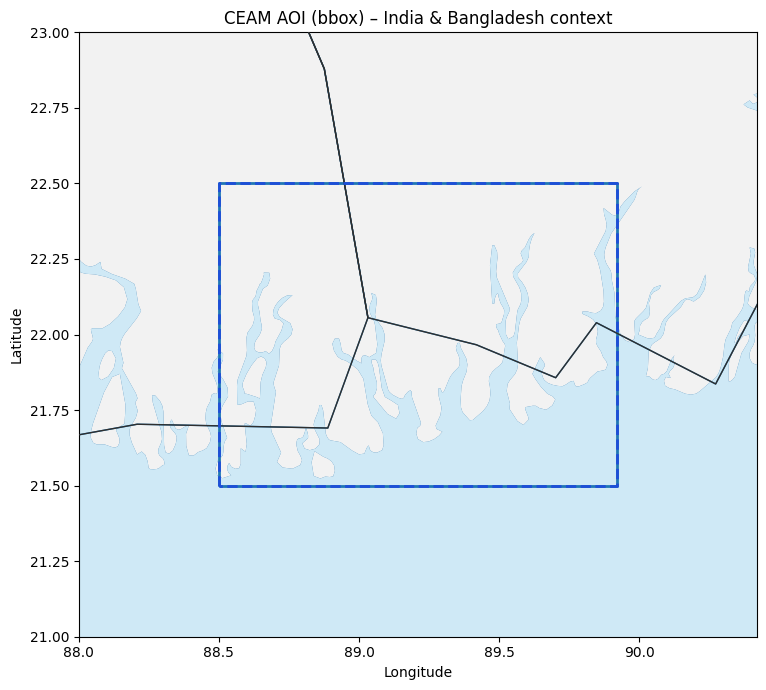

In [3]:
countries = gpd.read_file(COUNTRIES_SHP).to_crs("EPSG:4326")
land = gpd.read_file(LAND_SHP).to_crs("EPSG:4326")

region = countries[countries["NAME"].isin(["India", "Bangladesh"])]

bbox_gdf = gpd.GeoDataFrame(
    geometry=[box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])],
    crs="EPSG:4326",
)

pad_lon, pad_lat = 0.5, 0.5
xlim = (bbox["lon_min"] - pad_lon, bbox["lon_max"] + pad_lon)
ylim = (bbox["lat_min"] - pad_lat, bbox["lat_max"] + pad_lat)

fig, ax = plt.subplots(figsize=(10, 7))
land.plot(ax=ax, linewidth=0)
region.boundary.plot(ax=ax, linewidth=1)
bbox_gdf.boundary.plot(ax=ax, linewidth=2)

ax.set_title("CEAM AOI (bbox) – India & Bangladesh context")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_facecolor("#CFE9F6")  # water (very light blue)

# Land (Natural Earth 10m land)
land.plot(
    ax=ax,
    facecolor="#F2F2F2",   # land (very light gray)
    edgecolor="none",
    zorder=1
)

# Country borders (India/Bangladesh context)
region.boundary.plot(
    ax=ax,
    color="#2F2F2F",       # dark gray
    linewidth=1.0,
    zorder=3
)

# Your AOI bbox
bbox_gdf.boundary.plot(
    ax=ax,
    color="#1D4ED8",       # blue
    linewidth=2.0,
    linestyle="--",
    zorder=4
)

plt.tight_layout()
plt.show()


**Import Libraries**

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import contextily as cx


ModuleNotFoundError: No module named 'contextily'

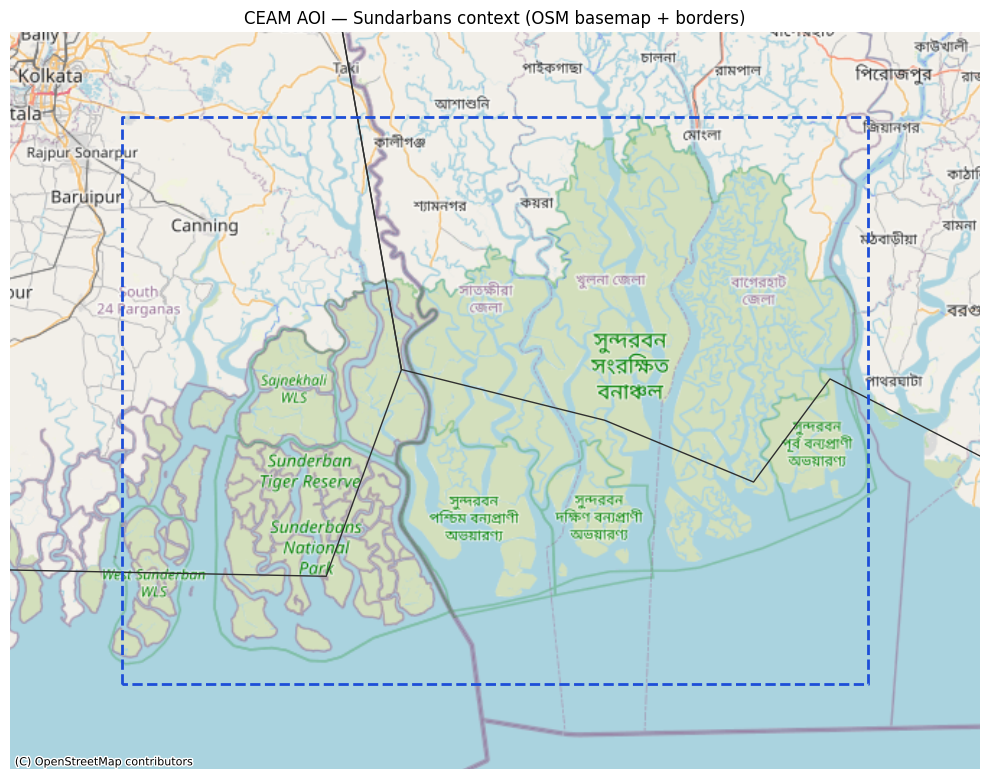

In [6]:
# bbox = {"lon_min": 88.08, "lat_min": 21.50, "lon_max": 89.92, "lat_max": 22.67}

# NE_DIR = "../data/basemaps/natural_earth"
# COUNTRIES_SHP = f"{NE_DIR}/ne_110m_admin_0_countries.shp"

countries = gpd.read_file(COUNTRIES_SHP).to_crs("EPSG:4326")
region = countries[countries["NAME"].isin(["India", "Bangladesh"])]

bbox_gdf = gpd.GeoDataFrame(
    geometry=[box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])],
    crs="EPSG:4326",
)

# Project to Web Mercator for basemap tiles
region_3857 = region.to_crs(epsg=3857)
bbox_3857 = bbox_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))

# 1) Set extent FIRST (in EPSG:3857)
xmin, ymin, xmax, ymax = bbox_3857.total_bounds
pad_x = (xmax - xmin) * 0.15
pad_y = (ymax - ymin) * 0.15
ax.set_xlim(xmin - pad_x, xmax + pad_x)
ax.set_ylim(ymin - pad_y, ymax + pad_y)

# 2) Now draw basemap for THIS extent
import contextily as cx
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=9)

# 3) Overlays on top
region_3857.boundary.plot(ax=ax, color="#2F2F2F", linewidth=1.0, zorder=3)
bbox_3857.boundary.plot(ax=ax, color="#1D4ED8", linewidth=2.0, linestyle="--", zorder=4)

ax.set_title("CEAM AOI — Sundarbans context (OSM basemap + borders)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


curl -G "https://overpass-api.de/api/interpreter" \
  --data-urlencode 'data=
[out:json][timeout:120];
(
  relation["name"~"Sundarbans",i](21.50,88.08,22.67,89.92);
  relation["boundary"="protected_area"]["name"~"Sundarbans",i](21.50,88.08,22.67,89.92);
  relation["leisure"="nature_reserve"]["name"~"Sundarbans",i](21.50,88.08,22.67,89.92);
  relation["protect_class"]["name"~"Sundarbans",i](21.50,88.08,22.67,89.92);
);
out tags center qt;
' | python -m json.tool


{
    "version": 0.6,
    "generator": "Overpass API 0.7.62.8 e802775f",
    "osm3s": {
        "timestamp_osm_base": "2025-12-30T11:33:45Z",
        "copyright": "The data included in this document is from www.openstreetmap.org. The data is made available under ODbL."
    },
    "elements": [
        {
            "type": "relation",
            "id": 14937802,
            "center": {
                "lat": 22.0209767,
                "lon": 89.3059518
            },
            "tags": {
                "boundary": "protected_area",
                "name": "Sundarbans",
                "name:bn": "\u09b8\u09c1\u09a8\u09cd\u09a6\u09b0\u09ac\u09a8",
                "name:zh": "\u5b59\u5fb7\u5c14\u672c\u65af",
                "type": "boundary",
                "wikidata": "Q4526",
                "wikipedia": "en:Sundarbans"
            }
        }
    ]
}

npm install -g osmtogeojson


```bash
REL_ID=14937802
mkdir -p data/basemaps/osm

curl -G "https://overpass-api.de/api/interpreter" \
  --data-urlencode "data=
[out:json][timeout:180];
relation(${REL_ID});
(._;>;);
out body;
" \
| osmtogeojson \
> data/basemaps/osm/sundarbans_relation_${REL_ID}.geojson
```

**Load and Keep Only Polygon**

In [7]:
import geopandas as gpd

sund = gpd.read_file("../data/basemaps/osm/sundarbans_relation_14937802.geojson")

# Keep only polygons (drop lines/points)
sund_poly = sund[sund.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()

print("Geoms:", sund.geometry.type.value_counts().to_dict())
print("Poly geoms:", sund_poly.geometry.type.value_counts().to_dict())
print("Poly bounds:", sund_poly.total_bounds)


Geoms: {'LineString': 34, 'Point': 6, 'Polygon': 1}
Poly geoms: {'Polygon': 1}
Poly bounds: [88.676409  21.5401969 89.9354946 22.5017564]


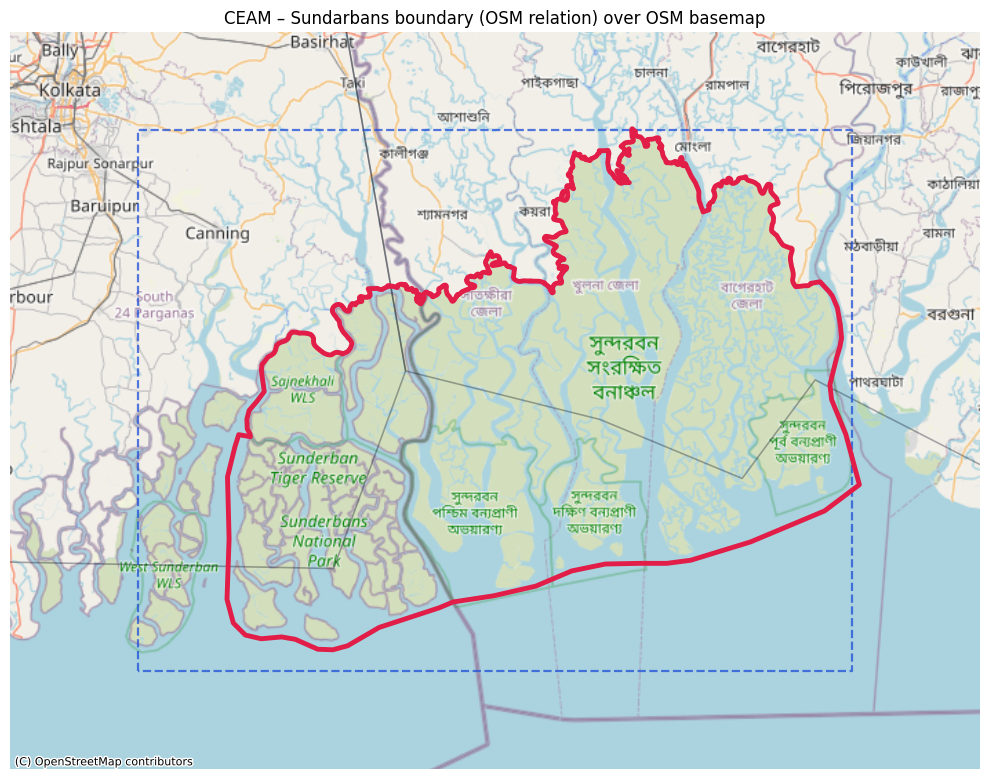

In [8]:
import contextily as cx
import matplotlib.pyplot as plt
from shapely.geometry import box

# bbox = {"lon_min": 88.08, "lat_min": 21.50, "lon_max": 89.92, "lat_max": 22.67}

# # Borders (Natural Earth)
# NE_DIR = "../data/basemaps/natural_earth"
# COUNTRIES_SHP = f"{NE_DIR}/ne_110m_admin_0_countries.shp"
# countries = gpd.read_file(COUNTRIES_SHP).to_crs("EPSG:4326")
# region = countries[countries["NAME"].isin(["India", "Bangladesh"])]

# bbox_gdf = gpd.GeoDataFrame(
#     geometry=[box(bbox["lon_min"], bbox["lat_min"], bbox["lon_max"], bbox["lat_max"])],
#     crs="EPSG:4326",
# )

# Project to 3857 for tiles
region_3857 = region.to_crs(epsg=3857)
bbox_3857 = bbox_gdf.to_crs(epsg=3857)
sund_3857 = sund_poly.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 8))

# Set extent first
xmin, ymin, xmax, ymax = bbox_3857.total_bounds
pad_x = (xmax - xmin) * 0.18   # slightly more breathing room
pad_y = (ymax - ymin) * 0.18
ax.set_xlim(xmin - pad_x, xmax + pad_x)
ax.set_ylim(ymin - pad_y, ymax + pad_y)

# Basemap (keep Mapnik, but let it choose the right zoom automatically)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

# Context border (make it subtle so it doesn't fight the Sundarbans boundary)
region_3857.boundary.plot(ax=ax, color="#111827", linewidth=1.2, alpha=0.35, zorder=3)

# Sundarbans polygon overlay (hero outline)
sund_3857.plot(
    ax=ax,
    facecolor="none",
    edgecolor="#E11D48",
    linewidth=3.5,
    zorder=10
)

# Bbox (slightly quieter)
bbox_3857.boundary.plot(
    ax=ax,
    color="#1D4ED8",
    linewidth=1.6,
    linestyle="--",
    alpha=0.75,
    zorder=5
)

ax.set_title("CEAM – Sundarbans boundary (OSM relation) over OSM basemap")
ax.set_axis_off()
plt.tight_layout()
plt.savefig("../outputs/figures/ceam_sundarbans_admin_hero.png", dpi=300, bbox_inches="tight")
plt.show()


In [9]:
print("AOI bbox (EPSG:4326):", bbox)
print("bbox_3857 bounds:", bbox_3857.total_bounds)
print("sund_3857 bounds:", sund_3857.total_bounds)
print("region_3857 bounds:", region_3857.total_bounds)


AOI bbox (EPSG:4326): {'lon_min': 88.5, 'lat_min': 21.5, 'lon_max': 89.92, 'lat_max': 22.5}
bbox_3857 bounds: [ 9851774.93520471  2451599.08737786 10009848.61213116  2571663.04717365]
sund_3857 bounds: [ 9871412.69525606  2456409.09675154 10011573.4631132   2571874.67952194]
region_3857 bounds: [ 7589389.42046348   889589.55841096 10842803.54553966  4231219.37264593]
